In [1]:
import cv2
import dlib
import os
import matplotlib.pyplot as plt
import numpy as np

### 얼굴이 나온 사진 준비

In [2]:
import glob
image_paths = glob.glob('camera_sticker/images/IMG*.jpg')
print(image_paths)


['camera_sticker/images/IMG_4.jpg', 'camera_sticker/images/IMG_1.jpg', 'camera_sticker/images/IMG_3.jpg', 'camera_sticker/images/IMG_2.jpg']


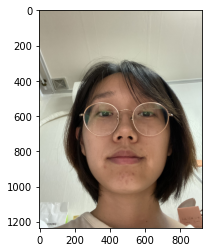

In [213]:
img_bgr = cv2.imread(image_paths[2])
img_bgr = cv2.resize(img_bgr, dsize=(0,0), fx=0.4, fy=0.4, 
                     interpolation=cv2.INTER_LINEAR)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 얼굴 검출 & 랜드마크 검출하기
dlib을 이용해서 얼굴의 bounding box 위치와 landmark 위치를 찾습니다.

rectangles[[(233, 480) (788, 1035)]]


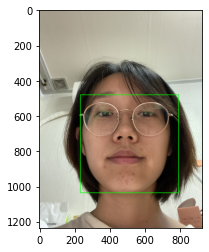

In [215]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()    
    r = dlib_rect.right()    
    b = dlib_rect.bottom() 
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


In [216]:
model_path = 'camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [217]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


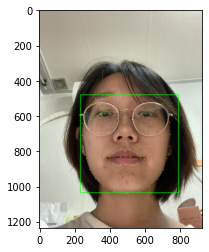

In [218]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


### 스티커 적용 위치 확인하기
landmark의 30번과 33번의 중간 위치를 이용해서 스티커를 적용할 위치를 잡습니다.

In [219]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    x = (landmark[30][0] + landmark[33][0]) // 2
    y = (landmark[30][1] + landmark[33][1]) // 2
    w = h = dlib_rect.width()
    print(f'(x,y): ({x},{y})')
    print(f'(w,h): ({w},{h})')

(485, 671)
(x,y): (486,708)
(w,h): (556,556)


In [220]:
sticker_path = os.path.join(os.getenv("HOME"), 'aiffel/camera_sticker/images/cat-whiskers.png')
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(556, 556, 3)


In [221]:
refined_x = x - w//2
refined_y = y - h//2
print(f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (208,430)


In [222]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y, :]
    refined_y = 0
print(f'(x,y) : {refined_x, refined_y})')

(x,y) : (208, 430))


### 스티커 적용하기
np.where를 활용하여 스티커를 적용합니다.  

In [223]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], 
         refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

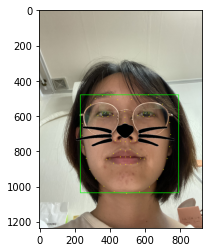

In [224]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

cv2.addWeighted를 이용해 반투명하게 스티커를 적용할 수도 있습니다.

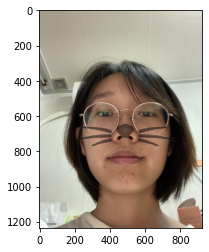

In [225]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
sticker_applied = np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

img_bgr[refined_y:refined_y+img_sticker.shape[0],
        refined_x:refined_x+img_sticker.shape[1]] = \
     cv2.addWeighted(sticker_area, 0.5, sticker_applied, 0.5, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 찾아보기

* 얼굴을 앞뒤로 기울인 각도에 따라서 스티커의 크기가 변해야 하고, **좌우로 회전한 각도에 따라 스티커도 회전해야 한다.**
* 너무 멀리서 촬영하면 얼굴이 인식하지 못할만큼 작으므로 안 될것이다.
* 90도 각도로 촬영하면?
* 실행속도?
* 정확도?

### 스티커 회전

얼굴이 세로축을 중심으로 회전함에따라서 스티커를 회전시켜보았습니다.

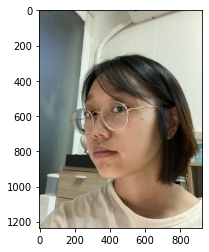

In [154]:
img_bgr = cv2.imread(image_paths[3])
img_bgr = cv2.resize(img_bgr, dsize=(0,0), fx=0.4, fy=0.4, 
                     interpolation=cv2.INTER_LINEAR)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(142, 451) (605, 913)]]


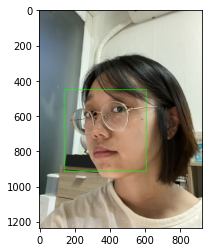

68


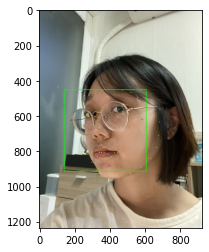

In [155]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()    
    r = dlib_rect.right()    
    b = dlib_rect.bottom() 
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


model_path = 'camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


(321, 675)
(x,y): (345,675)
(w,h): (464,464)
(464, 464, 3)


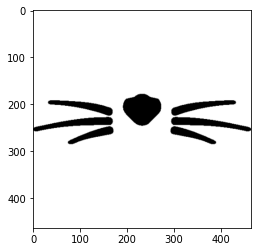

In [156]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    x = landmark[33][0] #+ landmark[33][0]) // 2
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print(f'(x,y): ({x},{y})')
    print(f'(w,h): ({w},{h})')

    sticker_path = os.path.join(os.getenv("HOME"), 'aiffel/camera_sticker/images/cat-whiskers.png')
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    print(img_sticker.shape)
    plt.imshow(img_sticker)
    plt.show()

랜드마크의 0번-5번 사이 세로 길이와 11번-16번 사이 세로 길이를 가지고 스티커의 양변을 원근변환시켰습니다.

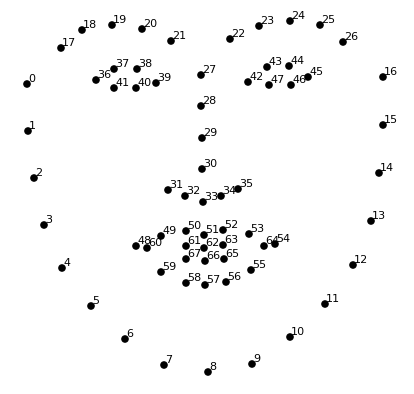

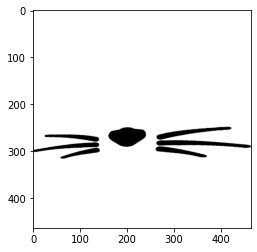

In [157]:
l = dlib_rect.left()
t = dlib_rect.top()

rows, cols = img_sticker.shape[:2]
pts1 = np.float32([(0,0), (0,rows), (cols,0), (cols, rows)])
pts2 = np.float32([(0, landmark[0][1]-t),
                   (0, landmark[5][1]-t),
                   (cols, landmark[16][1]-t), 
                   (cols, landmark[11][1]-t)])
mtrx = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(img_sticker, mtrx, (cols, rows), borderValue=(255,255,255))#,borderMode=cv2.BORDER_TRANSPARENT)
plt.imshow(dst)
plt.show()

(x,y) : (113,443)
(x,y) : (113, 443))


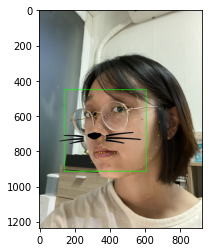

In [158]:
img_sticker = dst

refined_x = x - w//2
refined_y = y - h//2
print(f'(x,y) : ({refined_x},{refined_y})')

if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y, :]
    refined_y = 0
print(f'(x,y) : {refined_x, refined_y})')

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], 
         refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

박스와 랜드마크를 제거한 완성본입니다.

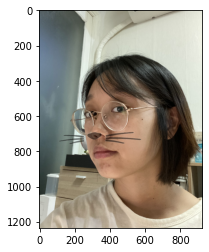

In [159]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0],
                        refined_x:refined_x+img_sticker.shape[1]]
sticker_applied = np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

img_bgr[refined_y:refined_y+img_sticker.shape[0],
        refined_x:refined_x+img_sticker.shape[1]] = \
     cv2.addWeighted(sticker_area, 0.5, sticker_applied, 0.5, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 회고

스티커 회전 구현은 수진님과 태종님이 도와주셔서 해낼수 있었습니다. 감사합니다!  
  
같은 뜻인데 반대로 표현되어 헷갈리는 것들이 많았습니다. BGR과 RGB, xy 좌표와 ndarray 인덱싱 순서, png 파일의 배경을 0으로 쓸때와 255로 쓸 때가 있는것.  

웹캠으로부터 영상을 받아와서 실시간으로 스티커를 입히는 앱을 만든다면 멋질것같습니다.

